In [ ]:
pip install langchain-huggingface

In [9]:
%pip install -qU langchain-google-genai

In [10]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12


In [8]:
!pip install langchain

In [6]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key:")

Enter your Google AI API key:··········


In [5]:
!pip install huggingface_hub

In [2]:
pip install -qU langchain-google-vertexai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.8 MB/s eta 0:00:00


In [3]:
%pip install -qU langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.3 MB/s eta 0:00:00


In [4]:
!pip install InstructorEmbedding


In [12]:
pip install --upgrade sentence-transformers transformers


In [ ]:
from google.colab import auth
auth.authenticate_user()


In [19]:
pip install -qU langchain-huggingface

In [26]:
pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.5 MB/s eta 0:00:00


In [40]:
import json
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain.docstore.document import Document

# Helper function to process grammar rules
def process_grammar_rules(data):
    chunks = []

    # Process verb conjugation rules
    for rule in data['sinhala_grammar_rules']['verb_conjugation_rules']:
        subject = rule['subject']
        for tense, details in rule['tense_endings'].items():
            chunks.append({
                'subject': subject,
                'tense': tense,
                'endings': details['endings'],
                'examples': details['examples'],
                'error_patterns': details['error_patterns']
            })

    # Process case markers
    for marker in data['sinhala_grammar_rules']['case_markers']:
        chunks.append({
            'case': marker['case'],
            'markers': marker['markers'],
            'examples': marker['examples'],
            'usage': marker['usage'],
            'error_patterns': marker['error_patterns']
        })

    # Process error detection patterns
    for error_pattern in data['sinhala_grammar_rules']['error_detection_patterns']:
        chunks.append({
            'error_type': error_pattern['error_type'],
            'pattern': error_pattern['pattern'],
            'examples': error_pattern['examples']
        })

    # Process temporal markers
    for temporal_marker in data['sinhala_grammar_rules']['temporal_markers'].values():
        for marker in temporal_marker:
            chunks.append({'temporal_marker': marker})

    return chunks

# Load Sinhala grammar rules data
with open('/content/sinhala_grammar.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Preprocess grammar rules
chunks = process_grammar_rules(data)

# Split chunks into smaller parts for indexing
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
formatted_chunks = [
    Document(page_content=json.dumps(chunk, ensure_ascii=False))
    for chunk in chunks
    for chunk in text_splitter.split_text(json.dumps(chunk, ensure_ascii=False))
]

# Initialize embeddings model
embeddings_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_store = FAISS.from_documents(formatted_chunks, embeddings_model)

# Initialize LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# Define prompt template
prompt_template = ChatPromptTemplate.from_template("""
<context>
{context}
</context>

Question: {input}

Please provide a corrected sentence and explain the errors.
""")

# Create document and retrieval chains
document_chain = create_stuff_documents_chain(llm, prompt_template)
retriever = vector_store.as_retriever()
retrieval_chain = create_retrieval_chain(retriever, document_chain)

# Context and query for Sinhala Grammar Error Checking
context = """Input:
You will receive a Sinhala sentence. It may contain grammatical errors, spelling mistakes, or both.

Output:
- Highlight errors in spelling or grammar.
- Explain the errors with examples.
- Provide the corrected sentence.

For example:
Input Sentence: "මම කෑම ගනිමු"
Output:
Errors Identified:
Grammar Error: Verb "ගනිමු" does not match the subject "මම."
Explanation: The subject "මම" requires the verb to end with "මි." Correct verb: "ගනිමි."
Corrected Sentence: "මම කෑම ගනිමි"
"""
query = "අපි උත්සාහයෙන් වැඩ කරමි. අපි කොහොමහරි දිනයි."

# Get response
response = retrieval_chain.invoke({"context": context, "input": query})

# Display the response
print("Response:")
print(response["answer"])


Response:
**Corrected Sentences:**

*   අපි උත්සාහයෙන් වැඩ කරමු.
*   අපි කොහොමහරි දිනමු.

**Explanation of Errors:**

1.  **"අපි උත්සාහයෙන් වැඩ කරමි"**
    *   **Error:** The verb ending "මි" is used with the subject "මම" (I) in the present tense. The subject here is "අපි" (we).
    *   **Correction:** The correct verb ending for "අපි" in the present tense is "මු" or "මුු". Therefore, "කරමි" should be "කරමු".

2.  **"අපි කොහොමහරි දිනයි"**
    *   **Error:** The verb ending "යි" is not used with the subject "අපි" (we) in the present tense.
    *   **Correction:** The correct verb ending for "අපි" in the present tense is "මු" or "මුු". Therefore, "දිනයි" should be "දිනමු".

**In summary:**

The errors in the original sentences were due to incorrect verb endings being used with the subject "අපි". The correct verb endings for "අපි" in the present tense are "මු" or "මුු".



## Sinhala Grammar Error Checker using LangChain and Google's Gemini.

This script utilizes LangChain and Google's Gemini language model to build a
Sinhala grammar error checker. It loads Sinhala grammar rules from a JSON file,
processes them, and creates a vector store using embeddings. The script then
defines a prompt template for error correction and explanation, and uses
retrieval chains to answer queries related to grammar rules.

Dependencies:
    - getpass
    - os
    - google.colab (for authentication and file access within Google Colab environment)
    - json
    - langchain (and its various components: text_splitter, embeddings, vectorstores, prompts, chains, etc.)
    - langchain-google-genai
    - langchain-community
    - huggingface_hub
    - sentence-transformers
    - transformers
    - faiss-gpu (for GPU-accelerated FAISS)
    - InstructorEmbedding
    - huggingface_hub (for Hugging Face embeddings)

Usage:
    1.  Install necessary libraries (see pip install commands in the script).
    2.  Authenticate with Google Cloud Platform (using `auth.authenticate_user()`).
    3.  Ensure your `GOOGLE_API_KEY` is set as an environment variable. If not,
        the script will prompt you to enter it.
    4.  Place the `sinhala_grammar.json` file in the `/content/` directory of your Google Colab environment.
    5.  Run the script.

Input:
    - The script expects a Sinhala sentence as input.
    - The script loads Sinhala grammar rules from a predefined JSON file.

Output:
    - The script analyzes the input Sinhala sentence.
    - It identifies grammatical errors or spelling mistakes.
    - Provides an explanation of the errors with examples.
    - Offers a corrected version of the input sentence.

Example:
Input Sentence: "මම කෑම ගනිමු"
Output:
Errors Identified:
Grammar Error: Verb "ගනිමු" does not match the subject "මම."
Explanation: The subject "මම" requires the verb to end with "මි." Correct verb: "ගනිමි."
Corrected Sentence: "මම කෑම ගනිමි"

Note:
The script uses the Gemini language model to generate the correction and explanation.
The accuracy of the result may depend on the quality of the grammar rules in the JSON
file and the language model's ability to understand and apply them.



## Project Report: Sinhala Grammar Error Checker

This project implements a Sinhala grammar error checker using LangChain and Google's Gemini language model.  It leverages a combination of techniques to analyze Sinhala sentences, identify errors, and provide corrections.

**1. Data Loading and Preprocessing:**

* **Data Source:** Sinhala grammar rules are loaded from a JSON file (`sinhala_grammar.json`). This file contains structured data about verb conjugation, case markers, error detection patterns, and temporal markers.
* **Data Processing:** The `process_grammar_rules` function parses the JSON data and transforms it into a more usable format.  It extracts relevant information from each rule type (verbs, cases, errors, temporal markers) and creates a list of dictionaries, where each dictionary represents a specific grammatical rule or pattern.
* **Text Splitting:**  The `RecursiveCharacterTextSplitter` from LangChain is employed to divide the grammar rules into smaller, manageable chunks (1000 characters with 100 character overlap). This is crucial for efficient embedding and retrieval.  The chunks are then converted into LangChain `Document` objects.

**2. Embeddings and Vector Store:**

* **Embeddings Model:** Sentence Transformers' `all-mpnet-base-v2` model is used to generate embeddings for each text chunk. This model creates numerical representations of the text, capturing semantic meaning.
* **Vector Store:** FAISS (Facebook AI Similarity Search) is used as the vector store to efficiently index the embeddings.  This allows for fast similarity searches when querying the model.  The use of `faiss-gpu` suggests leveraging GPU acceleration for improved performance.

**3. Language Model and Prompt Engineering:**

* **Language Model:** Google's Gemini language model (specifically `gemini-2.0-flash-exp`) is the core of the error checker. It's used to generate the corrected sentences and explanations.
* **Prompt Template:** A `ChatPromptTemplate` is defined to structure the input to the Gemini model.  The prompt includes:
    * `context`:  Provides background information on the task, emphasizing the expected input and output format (error identification, explanation, and corrected sentence).  A sample input-output pair is provided in the `context`.
    * `input`: The Sinhala sentence to be analyzed.
* **Chains:** LangChain's chains are used to combine the components.
    * `create_stuff_documents_chain`: Combines the LLM with the prompt template to generate the final response.
    * `create_retrieval_chain`: Connects the vector store retriever to the document chain. This allows the system to retrieve relevant grammar rules from the vector store based on the input sentence, use these rules in the prompt provided to the LLM and finally generate the response.


**4. Querying and Response Generation:**

* **Retrieval:** When a Sinhala sentence (the query) is input, the retrieval chain searches the vector store for the most relevant grammar rules.
* **Response Generation:**  The retrieved context (relevant grammar rules) and the input sentence are used to construct the prompt. This prompt is sent to the Gemini model.
* **Output:** The Gemini model provides the corrected sentence and an explanation of the errors, following the specified output format in the prompt.

**5. Libraries and Dependencies:**

The project relies on several key libraries:

* **LangChain:**  Provides the core framework for building the application, including components for text splitting, embeddings, vector stores, prompts, and chains.
* **Hugging Face Transformers:** Used for the Sentence Transformers embeddings model.
* **FAISS:**  Used for efficient similarity search in the vector store.
* **Google AI Platform:**  Provides access to the Gemini language model.
* **Other Libraries:**  `getpass`, `os`, `json`, `google.colab`, `InstructorEmbedding`, and others.

**Techniques Used:**

* **Embedding-based Retrieval:**  The use of embeddings and a vector store enables efficient retrieval of relevant grammar rules.
* **Large Language Models (LLMs):** Gemini's abilities in natural language processing are key to generating accurate corrections and explanations.
* **Prompt Engineering:** Carefully crafted prompts guide the LLM to produce the desired output.
* **Chain of Thought Prompting (implied):** While not explicitly stated, the provided context in the prompt likely helps guide the LLM through a chain of reasoning to arrive at the correct answer.
* **Chunking and Text Splitting:**  Breaking the grammar rules into smaller pieces allows for efficient vectorization.

**Overall, the project demonstrates a practical implementation of a grammar error checker using a combination of modern NLP techniques, specifically embeddings, vector databases and LLMs.**

# Outputs

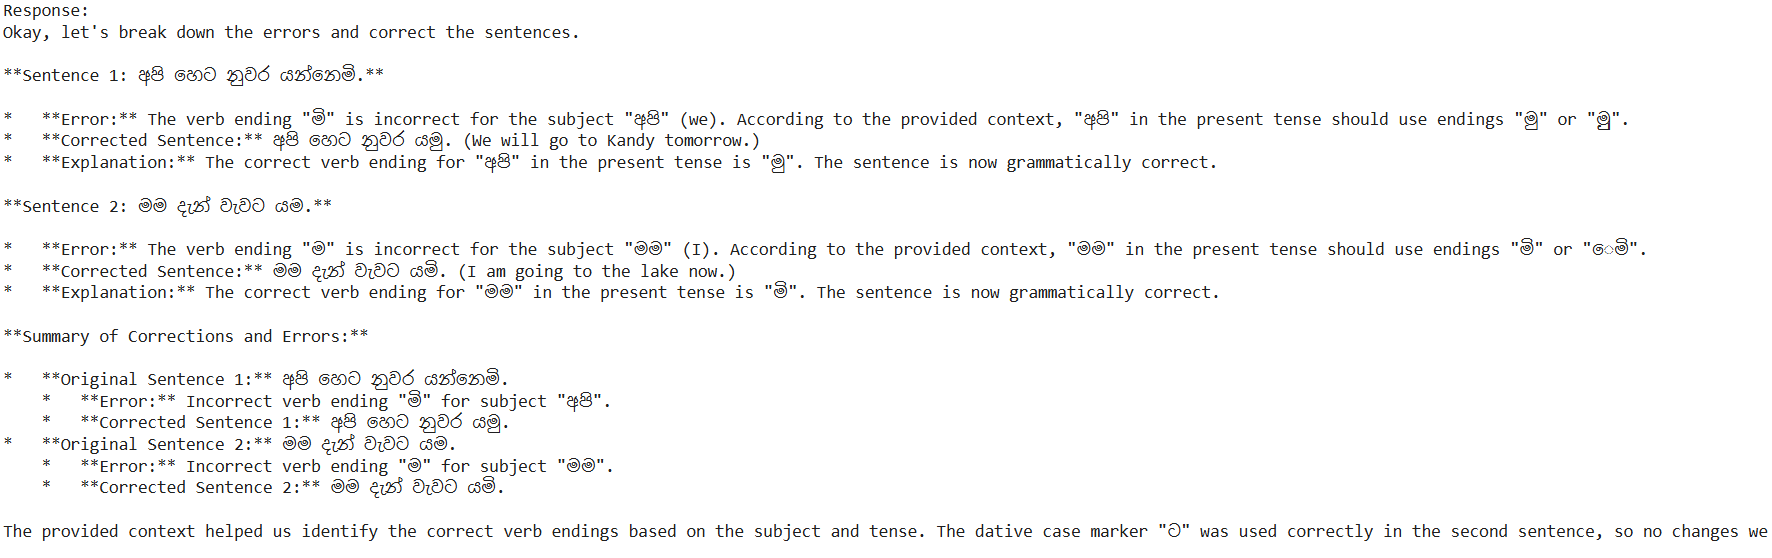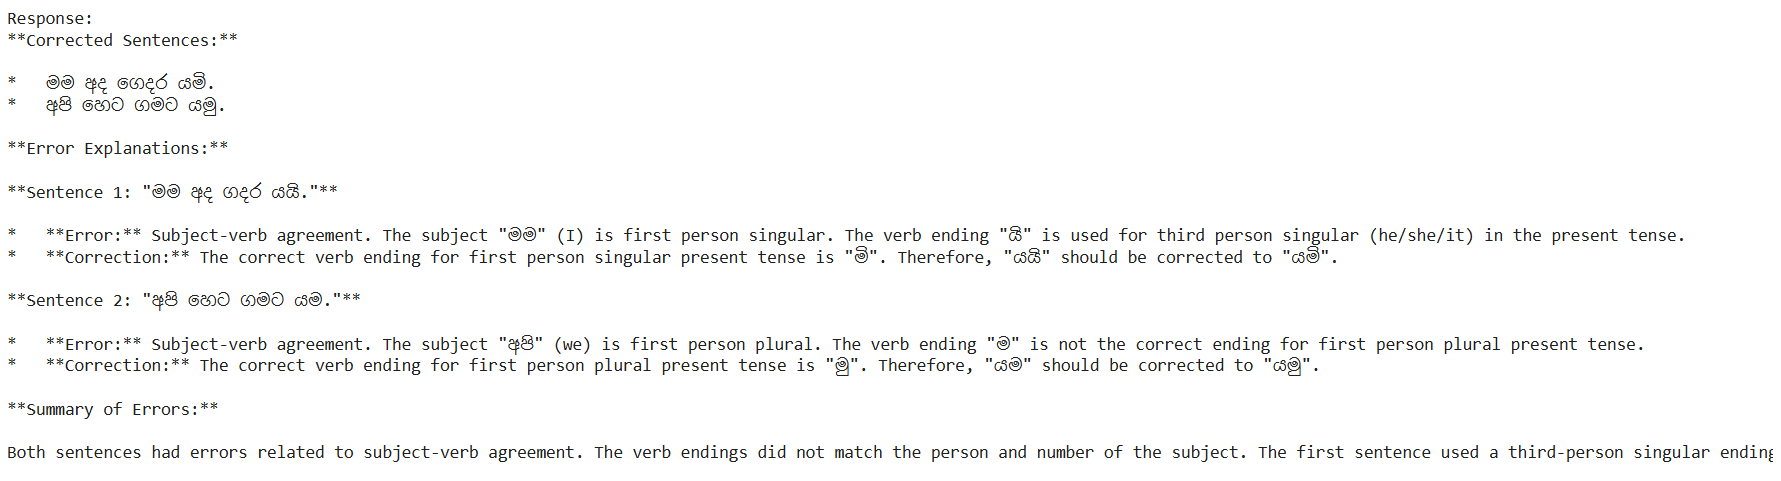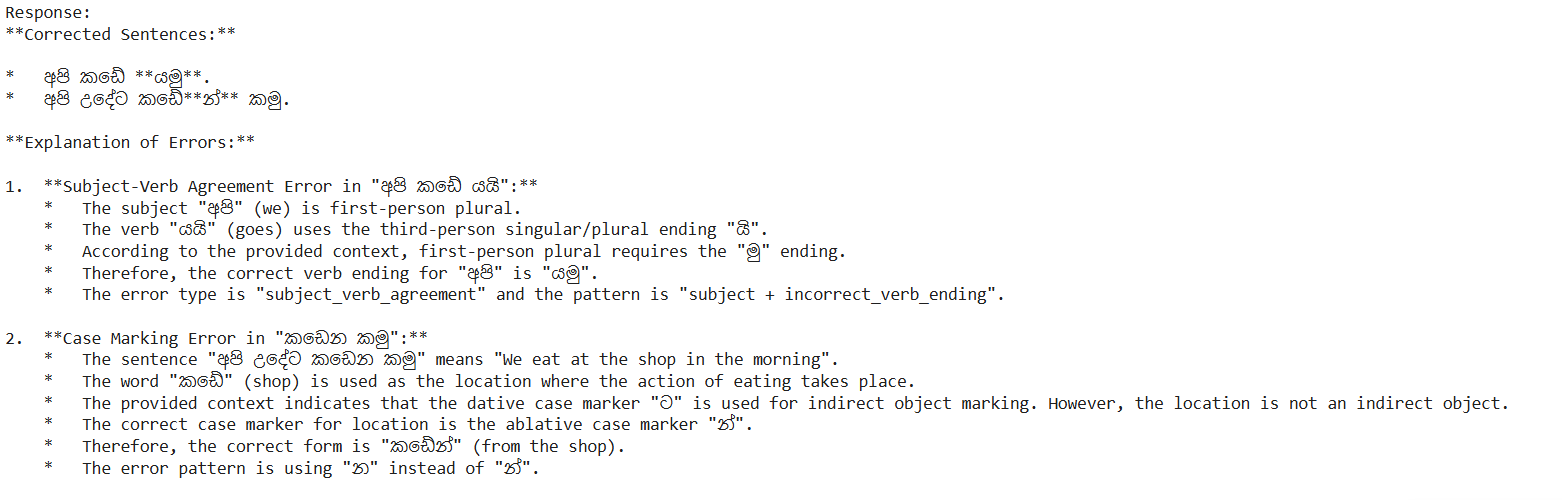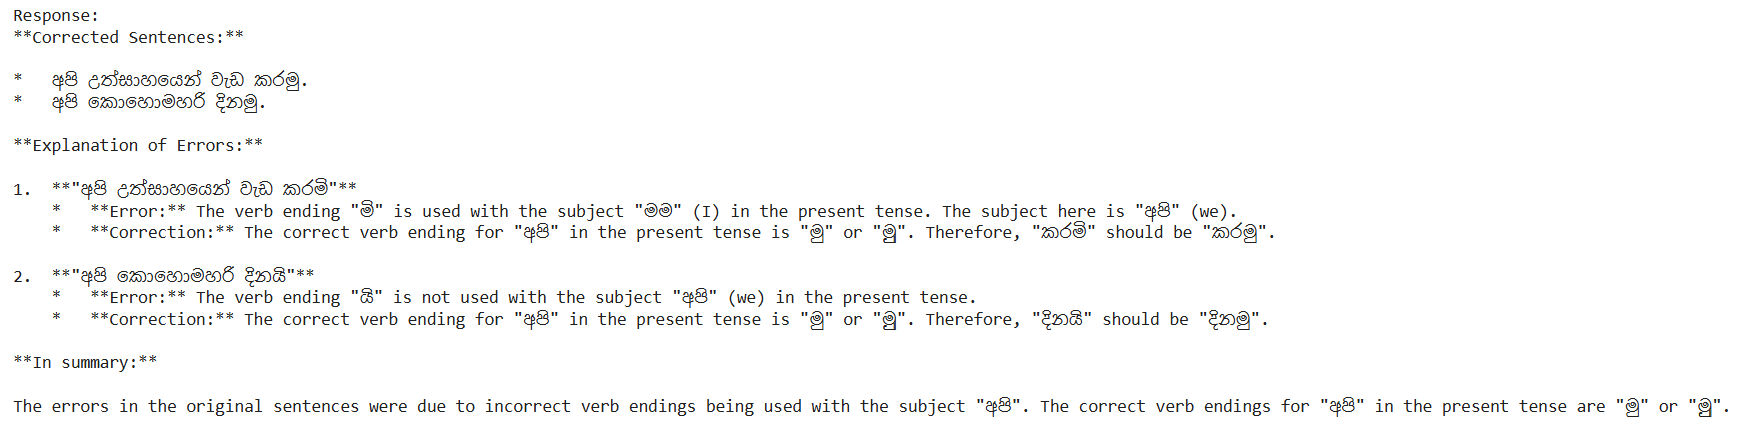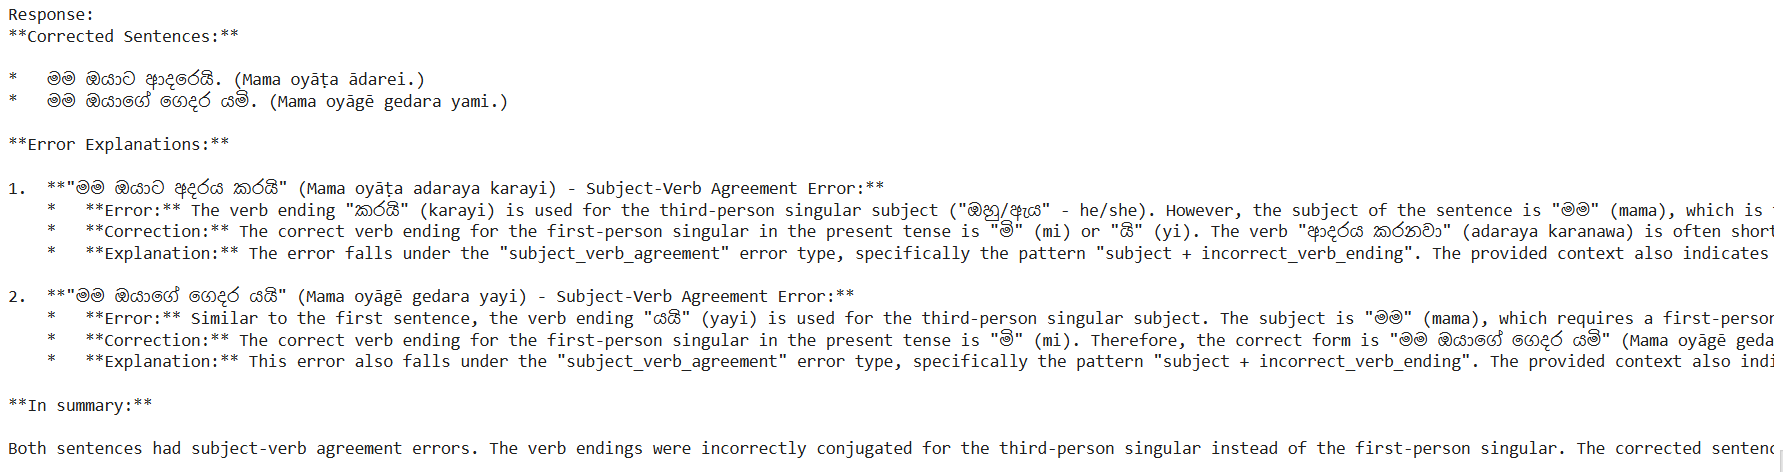